In [1]:
import tensorflow as tf
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Count by hand

- Day 22: 121 Akaina

In [2]:
# Constants
IMG_HEIGHT = 128
IMG_WIDTH = 128

ORIG_HEIGHT = 360
ORIG_WIDTH = 640

MODELS_PATH = 'models/'
STREAMS_PATH = 'streams/'
SCREENSHOTS_PATH = 'screenshots/'

EP = 22

In [99]:
prediction_model = tf.keras.models.load_model(MODELS_PATH + 'mobilenet_large.h5')

In [100]:
prediction_model.summary()

Model: "Transferred_mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 global_max_pooling2d_3 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_3 (Dense)             (None, 512)               655872    
                                                                 
 dropout_3 (Dropout)         (None, 512)     

In [5]:
def extractImages(pathIn, pathOut):
    count = 0
    vidcap = cv2.VideoCapture(pathIn)
    success, image = vidcap.read()
    success = True
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC, (count * 1000))  # added this line
        success, image = vidcap.read()
        if success:
            cv2.imwrite(pathOut + "\\frame%d.png" % count, image)  # save frame as JPEG file
        count = count + 1


In [7]:
screenshots_path = Path(SCREENSHOTS_PATH + str(EP))
screenshots = list(screenshots_path.glob("*.png"))

In [31]:
# sort by frame index
def get_frame_idx(path: Path):
    frame = path.stem
    # format -> frame0
    return int(frame.split('e')[1])
screenshots = sorted(screenshots, key=lambda x: get_frame_idx(x))

In [84]:
def prepare_img(path: Path):
    img = tf.io.read_file(str(path))
    img = tf.io.decode_png(img, channels=3)
    offset = -80
    left = (ORIG_WIDTH - 128) // 2 - offset
    top = (ORIG_HEIGHT - 128) // 2
    img = tf.image.crop_to_bounding_box(img, top , left, 128, 128)
    return img

(128, 128, 3)


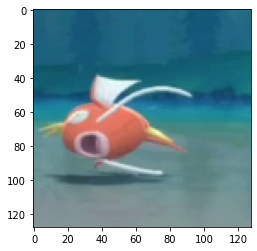

In [85]:
processed = prepare_img(screenshots[315])
print(processed.shape)
plt.imshow(processed)

In [86]:

def decode_one(x, threshhold = 0.5):
    return 1 if x > threshhold else 0

def predict_one(path):
    processed = prepare_img(path)
    data = np.array([processed])
    pred_raw = prediction_model.predict(data)
    prediction = decode_one(pred_raw)
    return prediction


In [87]:
d = prepare_img(screenshots[315])
d = np.array([d])
pred_raw = prediction_model.predict(d)
prediction = decode_one(pred_raw)
prediction

1

In [88]:
predictions = []

for path in screenshots:
    pred = predict_one(path)
    predictions.append(pred)

In [89]:
print("Total number of predictions", len(predictions))
print("Total number of AKAI KOI screen", len([p for p in predictions if p > 0]))

Total number of predictions 7583
Total number of AKAI KOI screen 1190


# By Freq

In [90]:
freqs = []

current = 0

for p in predictions:
    if p == 0:
        current = 0
    else:
        current += 1
    freqs.append(current)



<BarContainer object of 7583 artists>

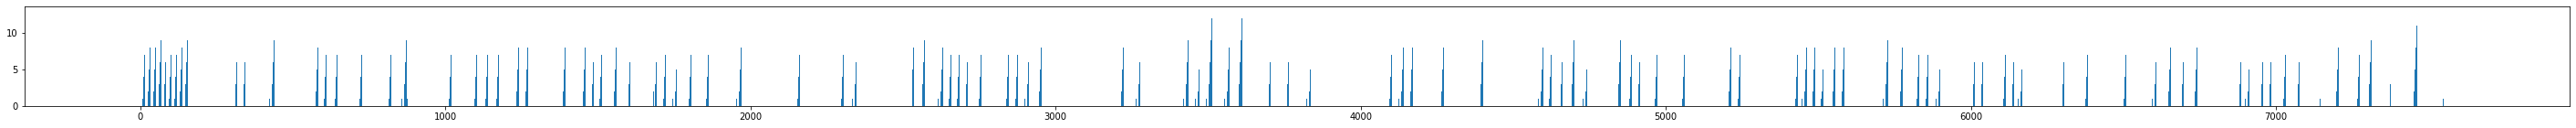

In [91]:
plt.figure(figsize=(50, 2))
plt.bar([i for i in range(len(freqs))], freqs)

In [92]:
filtered = [i for i, f in enumerate(freqs) if f >= 6]

In [93]:
len(filtered)

426

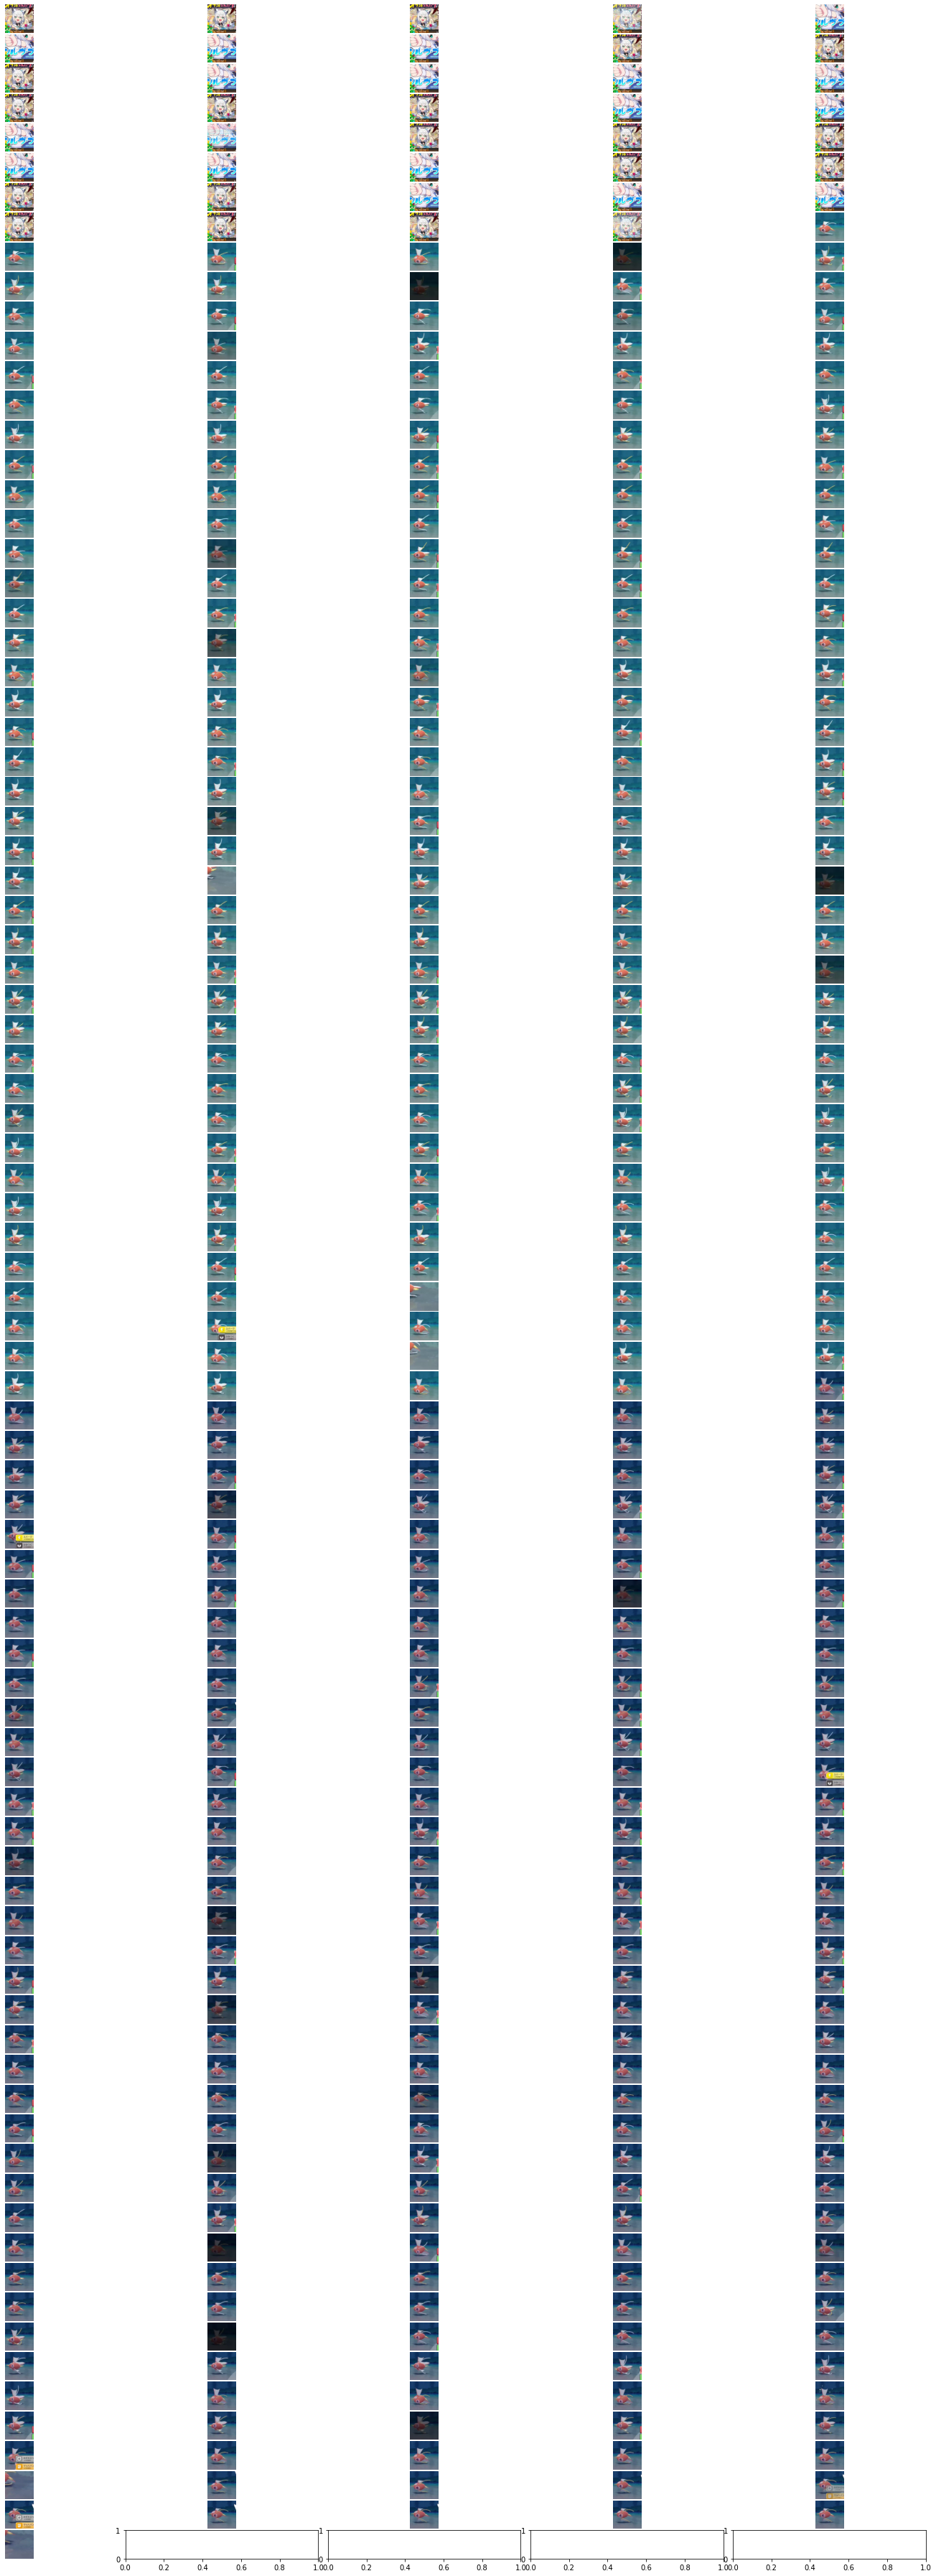

In [94]:
from PIL import Image

fig, ax = plt.subplots((len(filtered) // 5) + 1, 5, figsize=(20, 50))
fig.tight_layout() 
for i, idx in enumerate(filtered):
    ax[i // 5, i % 5].imshow(prepare_img(screenshots[idx]))
    ax[i // 5, i % 5].axis("off")
plt.subplots_adjust(wspace=.05, hspace=.05)

# By threshshold

In [95]:
# Throttle as 1 try if consecutive true, 
# and allow THRESHHOLD amount of false in between

# usually 1 - 2 sec downtime 
MAX_FALSE = 2

count = 0
current = False
threshold = 2
intervals = []
start = 0
for i, p in enumerate(predictions):
    if current:        
        if not p and not threshold:
            intervals.append((start, i))
            count += 1
            current = False
        if not p and threshold:
            threshold -= 1
        else:
            threshold = MAX_FALSE
    else:
        if p:
            start = i
            current = True





In [96]:
count

207

In [97]:
intervals

[(8, 19),
 (25, 36),
 (43, 53),
 (60, 71),
 (78, 88),
 (95, 106),
 (113, 123),
 (130, 140),
 (147, 158),
 (165, 175),
 (182, 193),
 (303, 306),
 (311, 320),
 (338, 348),
 (424, 427),
 (431, 442),
 (470, 480),
 (497, 507),
 (575, 585),
 (596, 599),
 (603, 613),
 (632, 635),
 (639, 649),
 (720, 730),
 (749, 759),
 (787, 797),
 (807, 810),
 (815, 825),
 (857, 860),
 (864, 879),
 (1013, 1023),
 (1034, 1037),
 (1041, 1051),
 (1088, 1091),
 (1096, 1105),
 (1124, 1127),
 (1132, 1141),
 (1168, 1178),
 (1226, 1229),
 (1233, 1244),
 (1256, 1259),
 (1263, 1275),
 (1327, 1337),
 (1385, 1395),
 (1451, 1461),
 (1472, 1475),
 (1480, 1490),
 (1499, 1502),
 (1506, 1517),
 (1553, 1563),
 (1592, 1595),
 (1600, 1610),
 (1622, 1625),
 (1629, 1639),
 (1681, 1685),
 (1686, 1696),
 (1708, 1711),
 (1715, 1725),
 (1745, 1750),
 (1753, 1762),
 (1799, 1809),
 (1848, 1851),
 (1856, 1866),
 (1894, 1897),
 (1901, 1915),
 (1954, 1957),
 (1962, 1972),
 (2147, 2150),
 (2155, 2165),
 (2290, 2293),
 (2298, 2307),
 (2334,

In [140]:
hit = []
buffers = []

In [141]:
def prepare_imgbuf(img):
    img = np.asarray(img).astype(np.float32)
    img = tf.convert_to_tensor(img)
    offset = -80
    left = (ORIG_WIDTH - 128) // 2 - offset
    top = (ORIG_HEIGHT - 128) // 2
    img = tf.image.crop_to_bounding_box(img, top, left, 128, 128)
    return img


def decode_one(x, threshhold=0.5):
    return 1 if x > threshhold else 0


def predict_buf(buf):
    processed = prepare_imgbuf(buf)
    data = np.array([processed])
    pred_raw = prediction_model.predict(data)
    prediction = decode_one(pred_raw)
    return prediction


def countByConfirms(pathIn):
    interval = 1000
    timestamp = 0
    vidcap = cv2.VideoCapture(pathIn)
    success, image = vidcap.read()
    confrim = 0
    start_at = 0
    while success:
        # Cap screenshots every interval ms
        vidcap.set(cv2.CAP_PROP_POS_MSEC, timestamp)  # added this line
        success, image = vidcap.read()
        if success:
            # send to prediction model
            prediction = predict_buf(image)

            if prediction:
                buffers.append(image)

            if confrim < 2:
                confrim = confrim + 1 if prediction else 0
                if confrim == 2:
                    start_at = timestamp

            if confrim == 2:
                interval = 500
                if not prediction:
                    confrim = 0
                    interval = 1000
                    hit.append((start_at, timestamp))
        timestamp += interval


In [142]:
countByConfirms(STREAMS_PATH + str(EP) + '.mp4')

In [143]:
print(len(hit))

155


{(2565000, 2565000), (4393000, 4393000), (582000, 582000), (1802000, 1802000), (1268000, 1268000), (7272000, 7272000), (1603000, 1603000), (2753000, 2753000), (5488000, 5488000), (7072000, 7072000), (3431000, 3431000), (1754000, 1754000), (6166000, 6166000), (6958000, 6958000), (6509000, 6509000), (7309000, 7309000), (314000, 314000), (1906000, 1906000), (1456000, 1456000), (5060000, 5060000), (5860000, 5860000), (6652000, 6652000), (5775000, 5775000), (7452000, 7452000), (1334000, 1334000), (6910000, 6910000), (1857000, 1857000), (608000, 608000), (6604000, 6604000), (3601000, 3601000), (752000, 752000), (2344000, 2344000), (4621000, 4621000), (2495000, 2495000), (4515000, 4515000), (1238000, 1238000), (4850000, 4850000), (1390000, 1390000), (1046000, 1046000), (4658000, 4658000), (2532000, 2532000), (4916000, 4916000), (475000, 475000), (6136000, 6136000), (818000, 818000), (6737000, 6737000), (4267000, 4267000), (5211000, 5211000), (6011000, 6011000), (3954000, 3954000), (1485000, 1

In [144]:
hit_second = [(h[0] / 1000, h[1] / 1000) for h in hit]

In [145]:
hit_second

[(312.0, 318.0),
 (339.0, 343.0),
 (345.0, 345.5),
 (432.5, 434.0),
 (471.0, 478.0),
 (499.0, 500.0),
 (504.0, 504.5),
 (575.5, 582.5),
 (604.5, 606.5),
 (609.5, 611.0),
 (640.0, 647.0),
 (721.0, 728.0),
 (750.0, 753.5),
 (755.5, 757.0),
 (816.0, 822.5),
 (865.5, 873.0),
 (876.0, 876.5),
 (1013.5, 1021.5),
 (1042.5, 1049.0),
 (1097.0, 1103.0),
 (1133.0, 1139.0),
 (1169.0, 1175.5),
 (1234.5, 1238.5),
 (1240.5, 1241.5),
 (1264.5, 1273.0),
 (1328.0, 1335.0),
 (1386.0, 1392.5),
 (1452.5, 1459.0),
 (1481.0, 1487.5),
 (1507.5, 1509.0),
 (1511.0, 1515.0),
 (1554.0, 1557.0),
 (1601.0, 1608.0),
 (1630.0, 1637.0),
 (1687.0, 1694.5),
 (1717.5, 1722.5),
 (1753.5, 1759.5),
 (1800.5, 1806.5),
 (1856.5, 1863.5),
 (1902.5, 1904.5),
 (1906.5, 1911.5),
 (1962.5, 1969.5),
 (2155.5, 2163.0),
 (2299.0, 2305.0),
 (2342.0, 2345.0),
 (2347.0, 2348.0),
 (2491.0, 2497.0),
 (2528.0, 2536.5),
 (2563.5, 2570.5),
 (2575.5, 2576.0),
 (2624.0, 2631.0),
 (2652.0, 2659.0),
 (2679.0, 2685.5),
 (2706.5, 2714.0),
 (2751.0

In [146]:
print(len(buffers))

1660


In [111]:
from PIL import Image

In [147]:
start_at = 3742
for i, buf in enumerate(buffers):
    buf = prepare_imgbuf(buf).numpy()
    cv2.imwrite(f"datasets/cropped/{start_at + i}.png", buf)